In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/tessivinjack/Documents/GitHub/Pstat134-Movie-Recommender-System/results':
  os.chdir(r'/Users/tessivinjack/Documents/GitHub/Pstat134-Movie-Recommender-System/results')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


/var/folders/vf/rnml667n67142sqyvw8fv12r0000gn/T/ipykernel_84457/2633715402.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/importlib/_bootstrap.py": 1680654106.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/importlib/_bootstrap_external.py": 1680654106.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/zipimport.py": 1680654104.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/codecs.py": 1680654104.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/encodings/aliases.py": 1680654105.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/encodings/__init__.py": 1680654105.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/encodings/utf_8.py": 1680654105.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/abc.py": 1680654104.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/io.py": 1680654104.0, "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/stat.py": 1680654104.0, "/Libr

In [2]:
#| eval: false
# Loading necessary packages
import requests
import pandas as pd
import time

api_key = "d3e8d7fcb94be031986259192b4fdfb0"

# Base URLs
url = "https://api.themoviedb.org/3/movie/popular"
credits_url_template = "https://api.themoviedb.org/3/movie/{}/credits"
providers_url_template = "https://api.themoviedb.org/3/movie/{}/watch/providers"

# Number of pages to retrieve
total_pages = 200
all_movies = []

# Fetch popular movies
for page in range(1, total_pages + 1):
    parameters = {"api_key": api_key, "page": page}
    response = requests.get(url, params=parameters)
    
    if response.status_code == 200:
        data = response.json()
        movies = data["results"]
        
        for movie in movies:
            movie["movie_id"] = movie.pop("id")  # Rename 'id' to 'movie_id'
            movie["rating_average"] = movie.pop("vote_average")  # Rename 'vote_average' to 'rating_average'
            
            # Get cast names
            credits_url = credits_url_template.format(movie["movie_id"])
            credits_response = requests.get(credits_url, params={"api_key": api_key})
            if credits_response.status_code == 200:
                credits_data = credits_response.json()
                cast_names = {cast_member["name"] for cast_member in credits_data.get("cast", [])} 
                movie["cast_names"] = ", ".join(cast_names)  
            else:
                movie["cast_names"] = None
            
            # Get watch providers
            providers_url = providers_url_template.format(movie["movie_id"])
            providers_response = requests.get(providers_url, params={"api_key": api_key})
            if providers_response.status_code == 200:
                providers_data = providers_response.json()
                provider_names = set()  # Store unique provider names
                
                for region, provider_info in providers_data.get("results", {}).items():
                    for category, providers_list in provider_info.items():
                        if isinstance(providers_list, list):
                            provider_names.update(provider["provider_name"] for provider in providers_list)
                
                movie["watch_providers"] = ", ".join(provider_names)
            else:
                movie["watch_providers"] = None
            
            time.sleep(0.2)  # Short delay to avoid rate limiting
        
        all_movies.extend(movies)
    else:
        print("Error:", response.status_code)
    
    time.sleep(0.5)
    print(page)
    
# Convert to DataFrame
movie_content_df = pd.DataFrame(all_movies)

In [3]:
#| eval: false
# Load necessary packages
import requests
import pandas as pd
import time

api_key = "d3e8d7fcb94be031986259192b4fdfb0"

# Base URLs
popular_movies_url = "https://api.themoviedb.org/3/movie/popular"
reviews_url_template = "https://api.themoviedb.org/3/movie/{}/reviews"

# Number of pages to retrieve
total_pages = 200 
all_movies = []

# Fetch popular movies
for page in range(1, total_pages + 1):
    parameters = {"api_key": api_key, "page": page}
    response = requests.get(popular_movies_url, params=parameters)
    
    if response.status_code == 200:
        data = response.json()
        all_movies.extend(data["results"])
    else:
        print("Error:", response.status_code)
        break

    time.sleep(0.5)  # Prevent rate-limiting
    print(page)

# Convert movies to DataFrame
movies_df = pd.DataFrame(all_movies)

# Fetch reviews for each movie
reviews_data = []

timeout_duration = 0.5

for movie_id in movies_df["id"]:
    response = requests.get(reviews_url_template.format(movie_id), params={"api_key": api_key})
    
    if response.status_code == 200:
        reviews = response.json().get("results", [])
        for review in reviews:
            reviews_data.append({
                "movie_id": movie_id,
                "author": review.get("author", "Unknown"),
                "user_rating": review.get("author_details", {}).get("rating", None)  # Changed "rating" to "user_rating"
            })
    else:
        print("Error:", response.status_code)

    time.sleep(0.5)

# Convert reviews to DataFrame
movie_reviews_df = pd.DataFrame(reviews_data)

In [4]:
# Creates the dictionary of genre IDs and names
# Load necessary packages
import requests
import pandas as pd

api_key = "d3e8d7fcb94be031986259192b4fdfb0"

# Base URL
url = "https://api.themoviedb.org/3/genre/movie/list"

# Set parameters like the page number and API key
parameters = {
    "api_key": api_key,
    "page":1
}

# Make the GET request to fetch the data
response = requests.get(url, params=parameters)

# Check if the request was successful
if response.status_code == 200:
    genre_data = response.json()  # Convert response to JSON
    genres = genre_data["genres"]  # Extract the list of genres
    genre_dict = {genre["id"]: genre["name"] for genre in genres}  # Create dictionary
    print(genre_dict)  # Print the genre mapping

else:
    print("Error", response.status_code)

{28: 'Action', 12: 'Adventure', 16: 'Animation', 35: 'Comedy', 80: 'Crime', 99: 'Documentary', 18: 'Drama', 10751: 'Family', 14: 'Fantasy', 36: 'History', 27: 'Horror', 10402: 'Music', 9648: 'Mystery', 10749: 'Romance', 878: 'Science Fiction', 10770: 'TV Movie', 53: 'Thriller', 10752: 'War', 37: 'Western'}


In [5]:
#| echo: false

movie_reviews_df = pd.read_csv('../data/movie_reviews_data.csv')
movie_content_df = pd.read_csv('../data/movie_content_df.csv')
movies_df = pd.read_csv('../data/movies_data.csv')
pd.options.mode.chained_assignment = None

In [6]:
# Load necessary packages
import pandas as pd
import ast

def genre_preprocessing(dataframe):
    # Convert genre_ids to lists
    dataframe['genre_ids'] = dataframe['genre_ids'].apply(ast.literal_eval)
    
    # Map genre_ids to genre names
    dataframe['genre_ids'] = dataframe['genre_ids'].apply(lambda x: [genre_dict[genre_id] for genre_id in x])
    
    return dataframe


def content_preprocessing(dataframe):
      # Format genre_ids
      dataframe = genre_preprocessing(dataframe)
    
      # Select necessary columns
      dataframe = dataframe[['movie_id', 'title', 'release_date', 'genre_ids', 'original_language', 'cast_names', 'watch_providers', 'rating_average', 'vote_count']]
      
      return dataframe
    
# Apply the preprocessing function
movie_content_df = content_preprocessing(movie_content_df)

In [7]:
# Load necessary packages
import pandas as pd
import pycountry # for languages convertion
import pandas as pd
movie_content_df.columns
# Tidying `genre_ids` 
def clean_genre_ids(value):
    if isinstance(value, list):  # If it's already a list, clean and join
        return ', '.join(genre.strip() for genre in value)
    elif isinstance(value, str) and value.startswith('c(') and value.endswith(')'):
        # Handle string cases formatted like R's "c(...)"
        genres = [genre.strip().strip('"') for genre in value[2:-1].split(',')]
        return ', '.join(genres)
    return value  # Return as is if neither case

    # Apply the function to genre_ids column
movie_content_df['genre_ids'] = movie_content_df['genre_ids'].apply(clean_genre_ids)
    # Check genre_ids missing and type
movie_content_df['genre_ids'].isna().sum() # No missing data
movie_content_df['genre_ids'].apply(type).value_counts() # All are string type

# Tidying original language to be full word
def convert_language_code(code):
    try:
        language = pycountry.languages.get(alpha_2=code)
        return language.name
    except:
        return code  # no corresponding language, return original language code
movie_content_df['original_language'] = movie_content_df['original_language'].apply(convert_language_code)
movie_content_df["original_language"] = movie_content_df["original_language"].replace("cn", "Chinese") # cn to Chinese
movie_content_df["original_language"] = movie_content_df["original_language"].replace("xx", "Unknown") # xx to Unknown
    
# Editing data types
movie_content_df['rating_average'] = pd.to_numeric(movie_content_df['rating_average'], errors='coerce')
movie_content_df['rating_average'] = movie_content_df['rating_average'].round(0).astype(int) # vote_average to round
movie_content_df['vote_count'] = pd.to_numeric(movie_content_df['vote_count'], errors='coerce')

# Creating a `release_year` column
movie_content_df = movie_content_df.copy()  # Ensure movies_df is a separate DataFrame
movie_content_df["release_date"] = movie_content_df["release_date"].astype(str)
movie_content_df = movie_content_df[movie_content_df["release_date"] != '']
movie_content_df["release_year"] = pd.to_numeric(movie_content_df["release_date"].str[:4], errors = "coerce")
movie_content_df = movie_content_df.drop(columns=["release_date"])

# Changing the `title` type
  # Convert to pandas' new string type
movie_content_df["title"] = movie_content_df["title"].astype("string")
  # Check the dtype again
print(movie_content_df["title"].dtype)
    
# Editing `cast_names`
movie_content_df["cast_names"] = movie_content_df["cast_names"].replace("", pd.NA)

# Editing `watch_providers`
movie_content_df["watch_providers"] = movie_content_df["watch_providers"].replace("", pd.NA)

# Reordering column names
  # Define the new column order
new_column_order = ['movie_id', 'title', 'release_year', 'genre_ids', 'original_language', 'cast_names', 'watch_providers', 'rating_average', 'vote_count']
  # Reorganize columns in the DataFrame
movie_content_df = movie_content_df[new_column_order]

string


In [8]:
import pandas as pd
import ast

def genre_preprocessing(dataframe):
    # Convert genre_ids to lists
    dataframe['genre_ids'] = dataframe['genre_ids'].apply(ast.literal_eval)
    
    # Map genre_ids to genre names
    dataframe['genre_ids'] = dataframe['genre_ids'].apply(lambda x: [genre_dict[genre_id] for genre_id in x])
    
    return dataframe
    
def collab_preproccesing(dataframe):
      # Format genre_ids
      dataframe = genre_preprocessing(dataframe)
      
      # Select necessary columns
      dataframe = dataframe[['id', 'title', 'release_date', 'genre_ids', 'original_language', 'vote_count']]
      
      return dataframe

# Apply the preprocessing function
movies_df = collab_preproccesing(movies_df)

In [9]:
# Creating a `user_id` column
user_id_map = {}  # Dictionary to store author -> user_id mapping
current_id = 1

# Ensure 'user_id' column exists
movie_reviews_df["user_id"] = pd.NA  

# Get valid indices
valid_indices = movie_reviews_df["user_rating"].notna() & (movie_reviews_df["user_rating"] != "")

# Store user IDs in a list to avoid modifying DataFrame during iteration
user_ids = []

for idx, author in movie_reviews_df.loc[valid_indices, "author"].items():
    if author not in user_id_map:
        user_id_map[author] = current_id
        current_id += 1
    user_ids.append((idx, user_id_map[author]))

# Assign user IDs to the DataFrame
for idx, user_id in user_ids:
    movie_reviews_df.loc[idx, "user_id"] = user_id

# Convert `user_id` to integers (nullable type to allow NaN)
movie_reviews_df["user_id"] = movie_reviews_df["user_id"].astype("Int64")

# Drop the `author` column
movie_reviews_df = movie_reviews_df.drop(columns=["author"])

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from rich.console import Console
from rich.table import Table

console = Console()

table = Table(title = "Movie Dataset Variables", show_lines = True)

table.add_column("Variable Name", style = "cyan", justify = "left")
table.add_column("Description", style = "magenta", justify = "left")

table.add_row('movie_id', 'Unique identifier of the movie.')
table.add_row('title', 'Title of the movie.')
table.add_row('release_year', 'The year the movie was released.')
table.add_row('genre_ids', 'List of genres associated with a movie.')
table.add_row('original_language', 'Original language of the movie.')
table.add_row('cast_names', 'List of actors in the movie.')
table.add_row('watch_providers', 'Streaming platforms where the movie is available.')
table.add_row('rating_average', 'A quantitative assessment of the overall quality of a movie.')
table.add_row('vote_count', 'The total number of people who voted for the movie.')
table.add_row('author', 'Unique identifier for the user.')
table.add_row('user_rating', 'Rating given by user.')
console.print(table)

                              Movie Dataset Variables                               
┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Variable Name     ┃ Description                                                  ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ movie_id          │ Unique identifier of the movie.                              │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ title             │ Title of the movie.                                          │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ release_year      │ The year the movie was released.                             │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ genre_ids         │ List of genres associated with a movie.                      │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ original_language │ Original language of the movie.                              │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ cast_names        │ List of actors in the movie.                                 │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ watch_providers   │ Streaming platforms where the movie is available.            │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ rating_average    │ A quantitative assessment of the overall quality of a movie. │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ vote_count        │ The total number of people who voted for the movie.          │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ author            │ Unique identifier for the user.                              │
├───────────────────┼──────────────────────────────────────────────────────────────┤
│ user_rating       │ Rating given by user.                                        │
└───────────────────┴──────────────────────────────────────────────────────────────┘

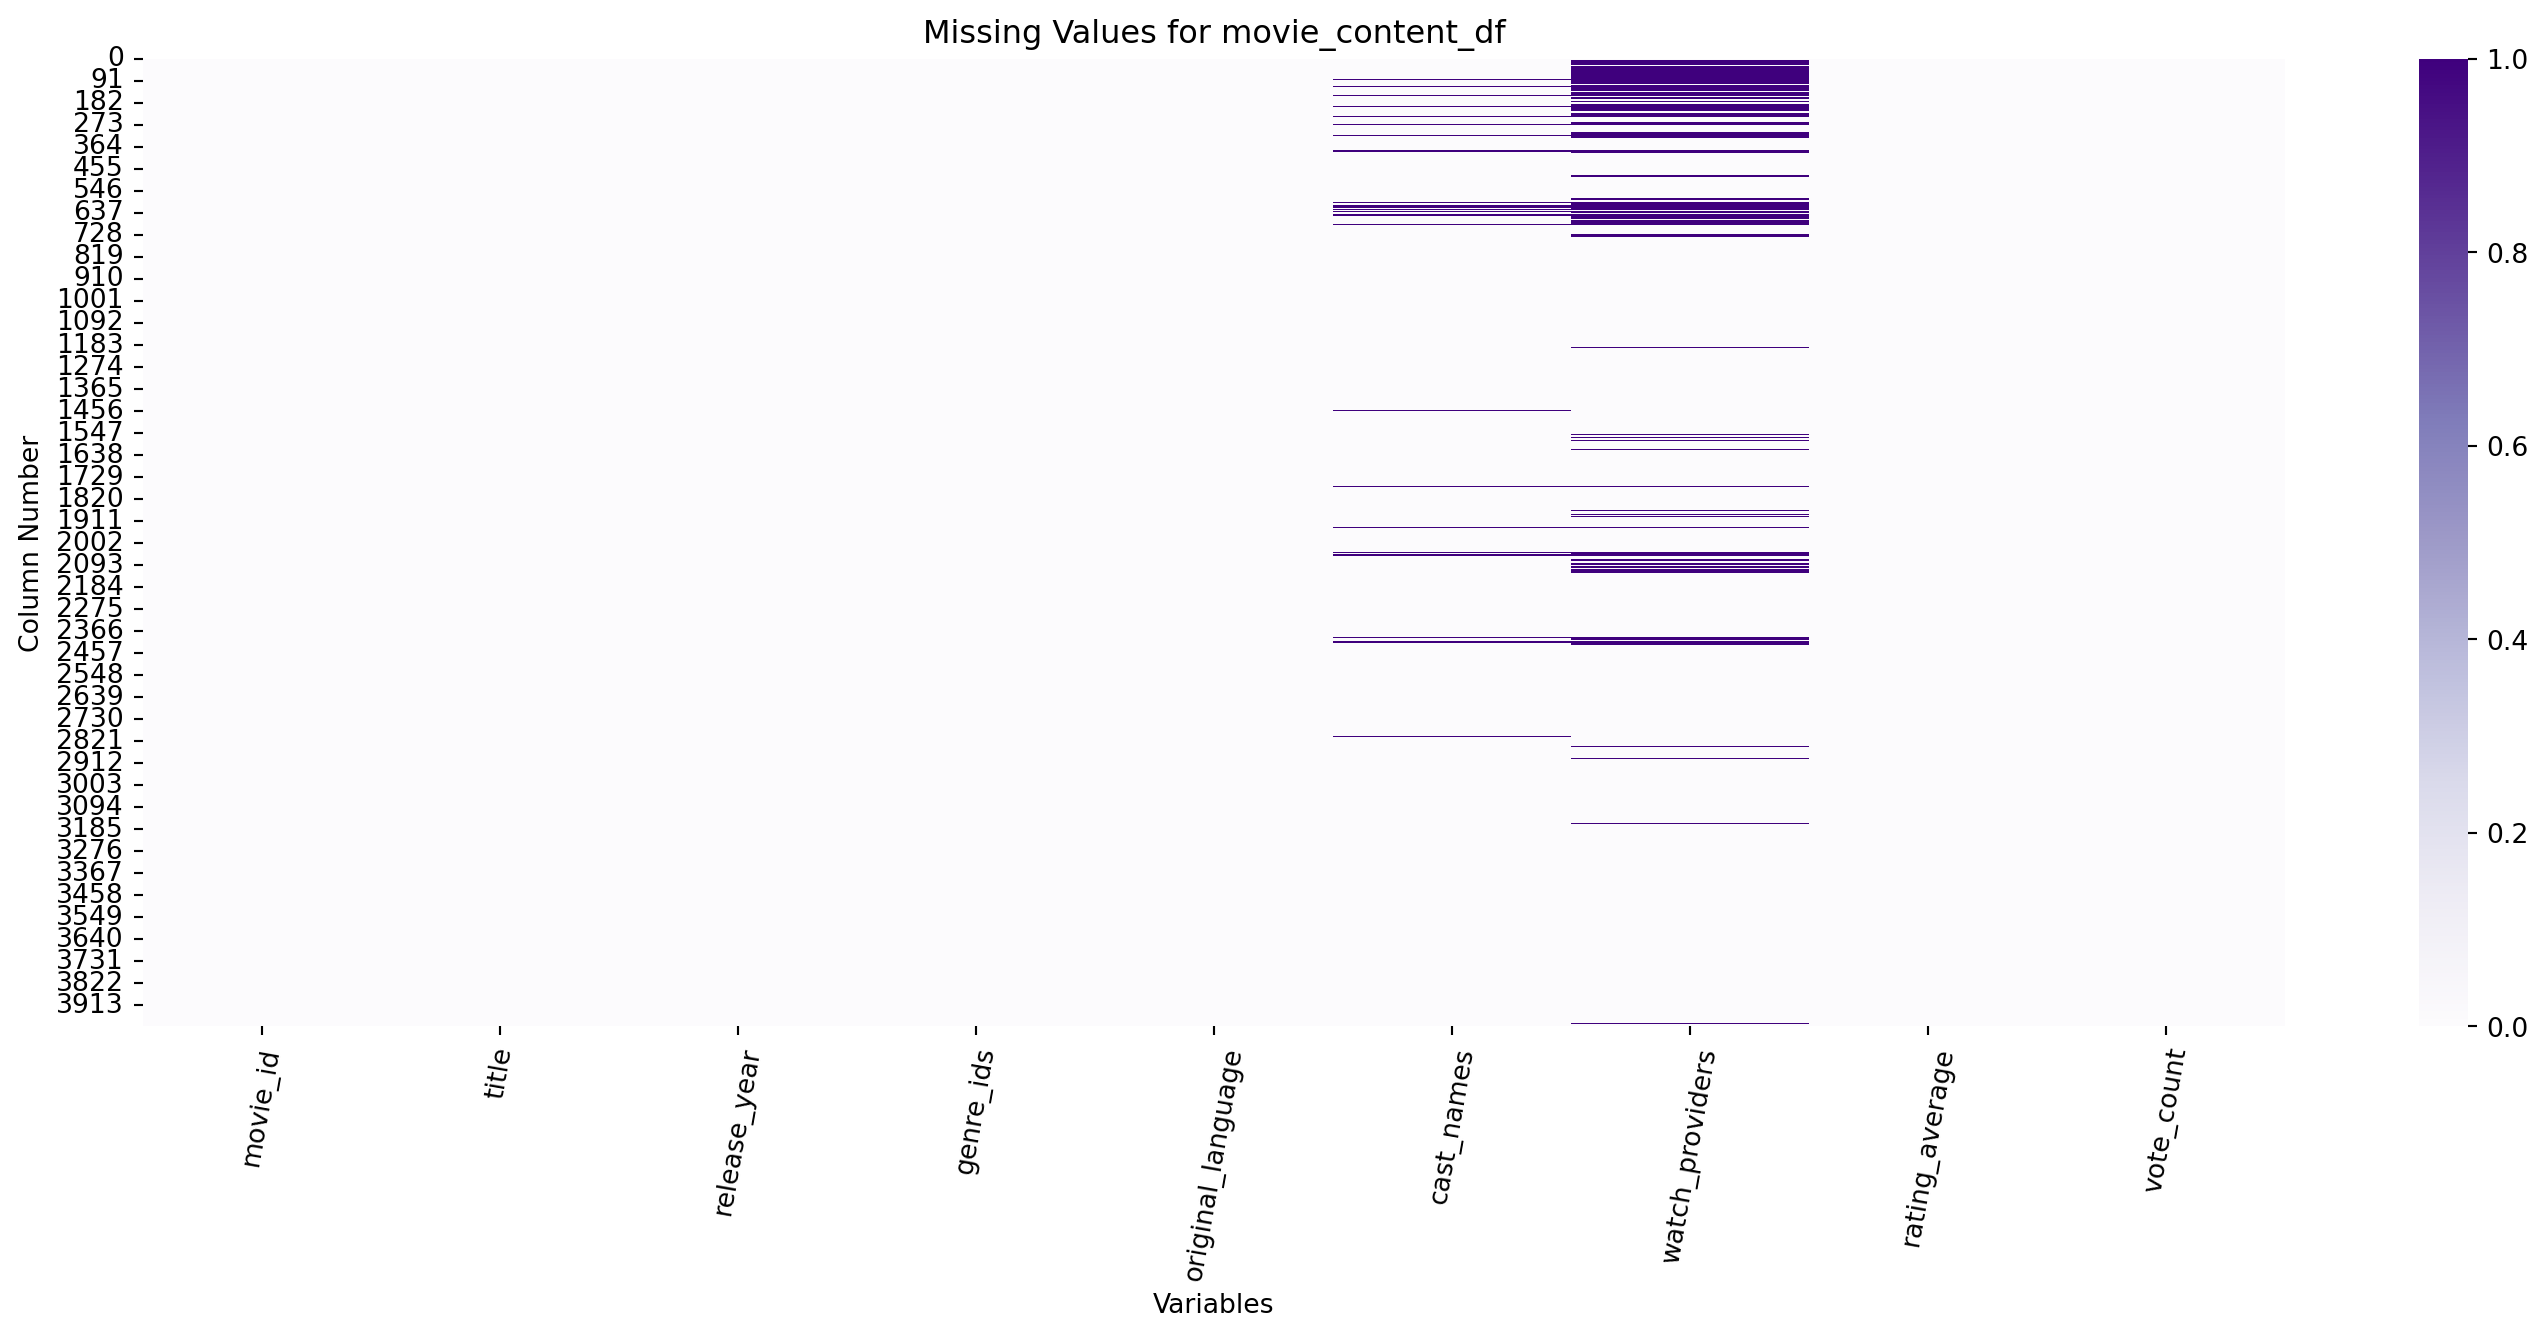

In [11]:
import warnings 
warnings.simplefilter(action ='ignore', category = FutureWarning)

#plotting missing values for movie_content_df
plt.figure(figsize = (18,8))
sns.heatmap(movie_content_df.isnull(), cmap = "Purples")
plt.xlabel('Variables')
plt.ylabel('Column Number')
plt.xticks(rotation = 80)
plt.title('Missing Values for movie_content_df')
plt.subplots_adjust(bottom = 0.25)
plt.show()

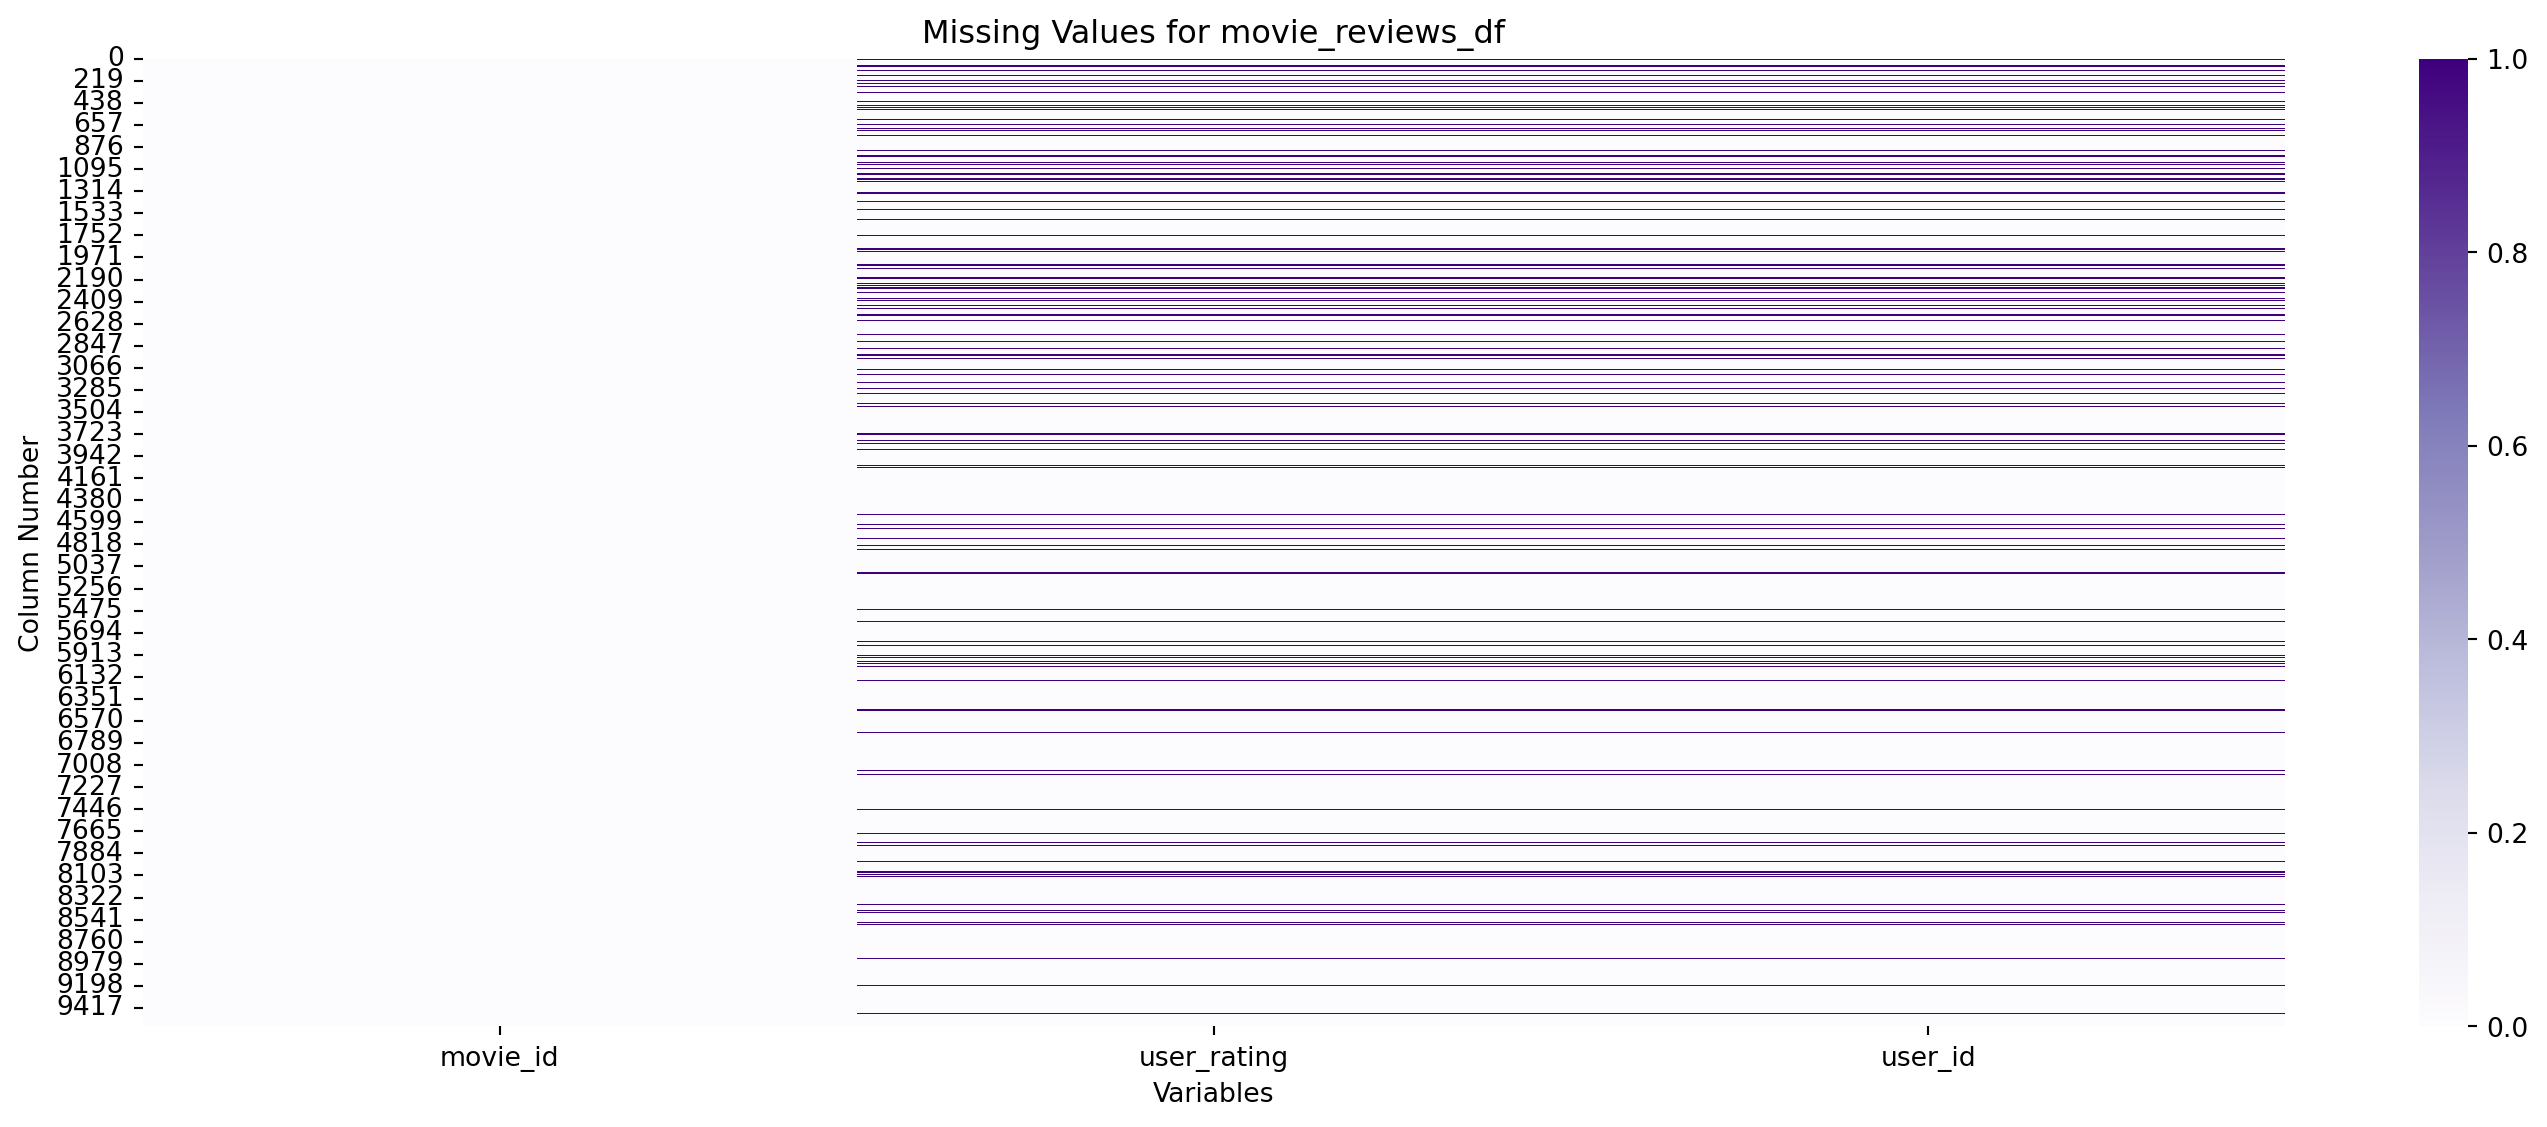

In [12]:
#plotting missing values for movie_reviews_df
plt.figure(figsize = (18,8))
sns.heatmap(movie_reviews_df.isnull(), cmap = "Purples")
plt.xlabel('Variables')
plt.ylabel('Column Number')
plt.title('Missing Values for movie_reviews_df')
plt.subplots_adjust(bottom = 0.25)
plt.show()

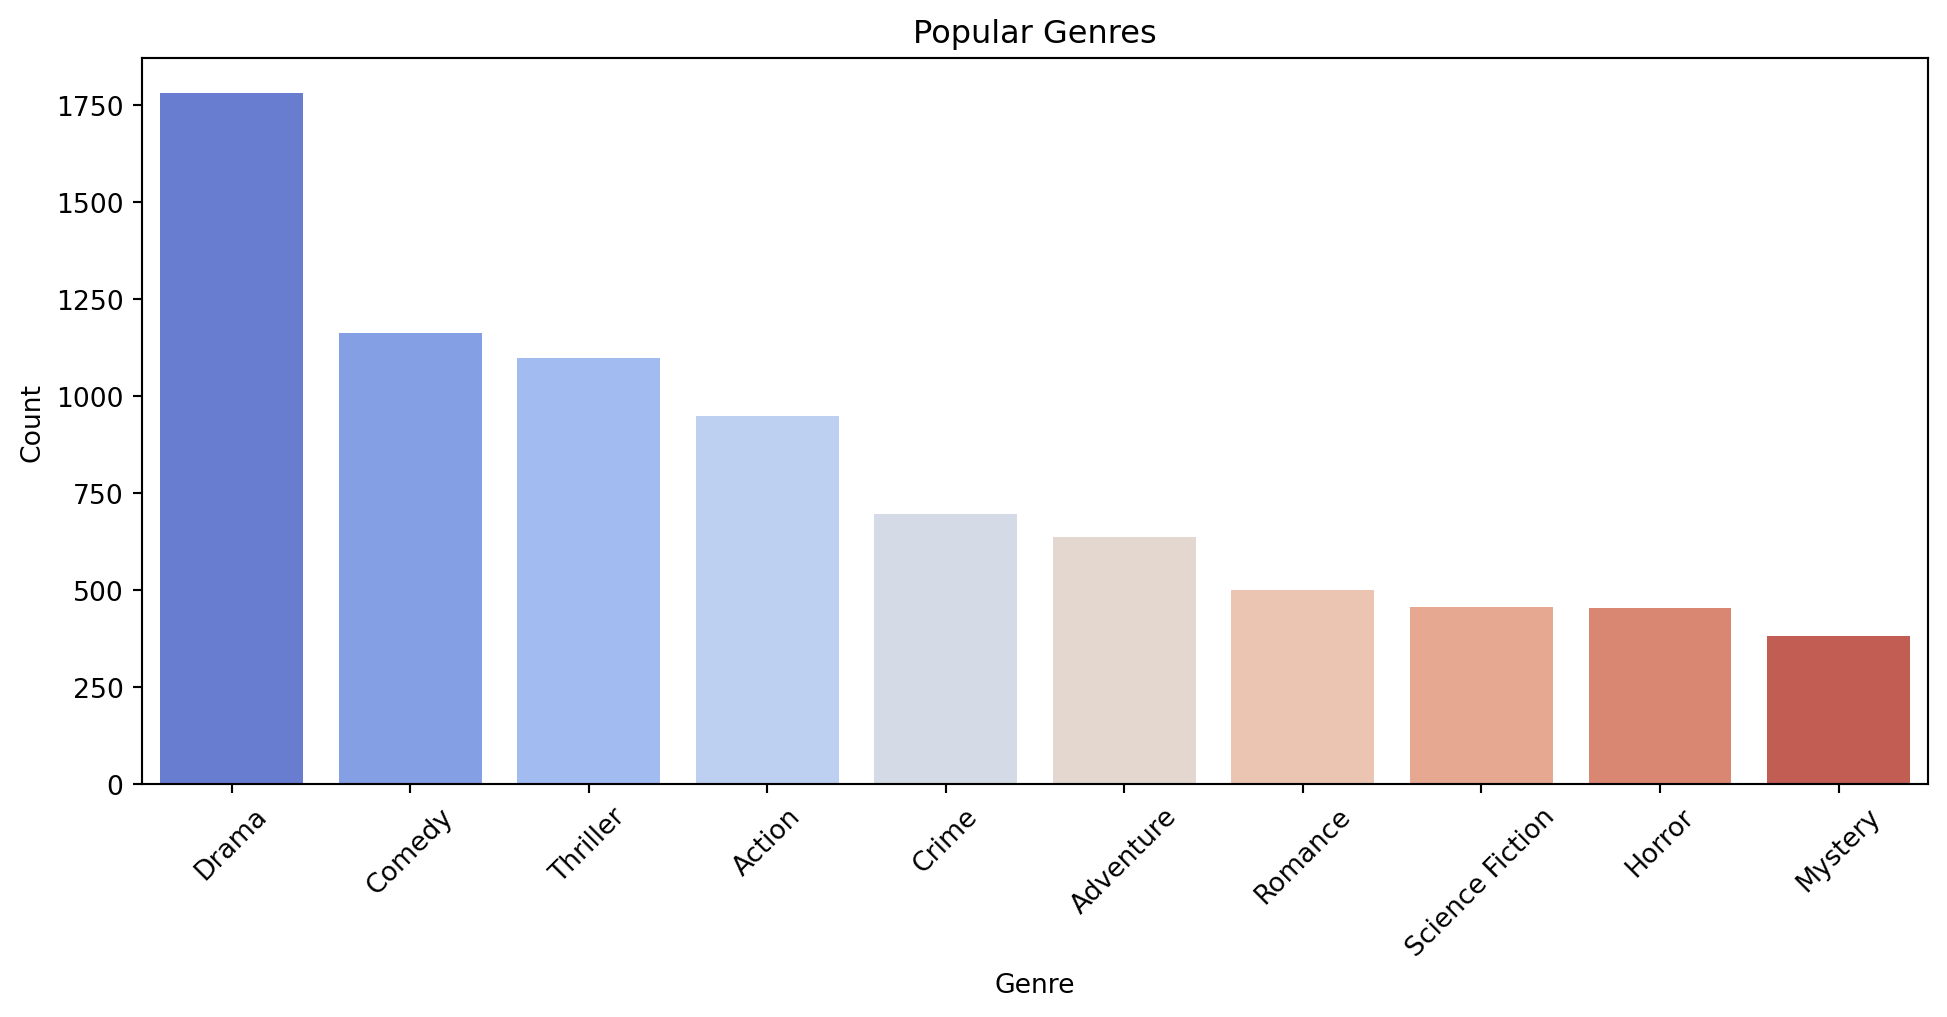

In [13]:
#separating genres and exploding
movie_content_df['genre_ids'] = movie_content_df['genre_ids'].fillna('').astype(str)
movie_content_df['genre_list'] = movie_content_df['genre_ids'].apply(lambda x: [genre.strip() for genre in x.split(',')])
movies_exploded = movie_content_df.explode('genre_list')

#bar chart for genre counts
genre_counts = movies_exploded['genre_list'].value_counts()
plt.figure(figsize = (12, 6))
sns.barplot(x = genre_counts.index[:10], y = genre_counts.values[:10], palette = "coolwarm")
plt.xticks(rotation = 45)
plt.xlabel('Genre')
plt.ylabel('Count')
plt.title('Popular Genres')
plt.subplots_adjust(bottom = .25)
plt.show()

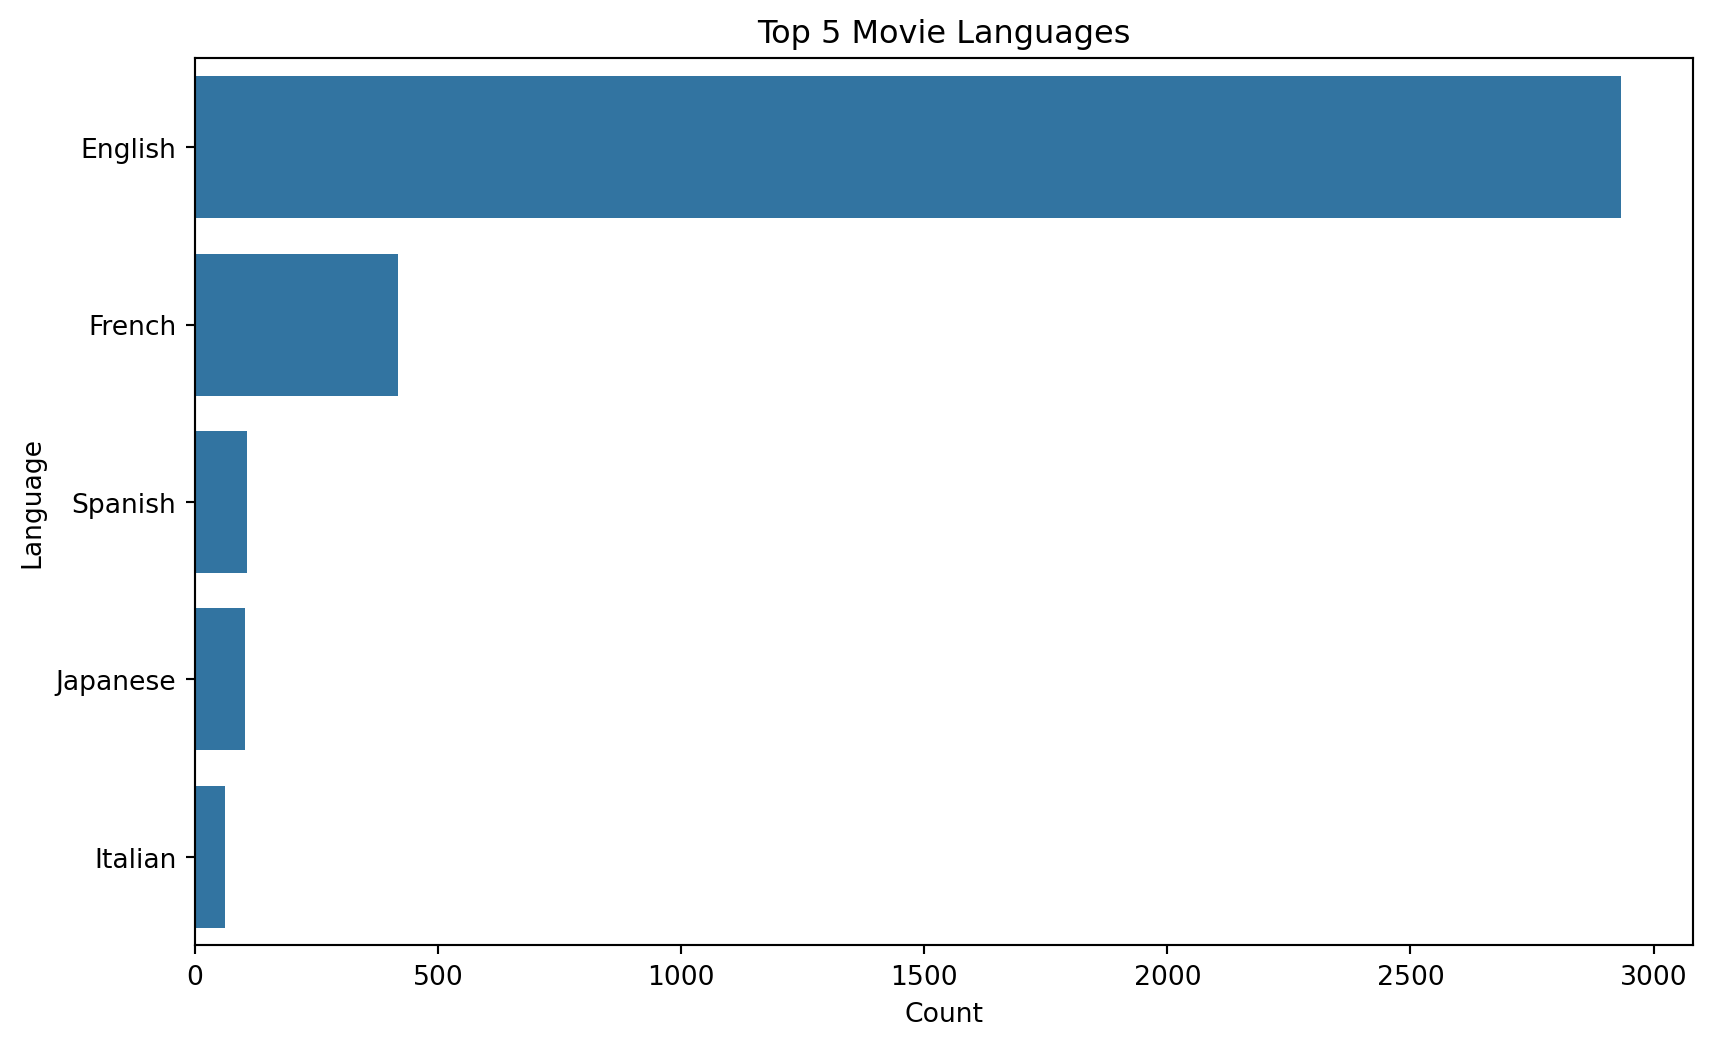

In [14]:
#countplot for languages
plt.figure(figsize = (12, 6))
sns.countplot(y = 'original_language', data = movie_content_df, order = movie_content_df['original_language'].value_counts(ascending = False).index[:5])
plt.xlabel('Count')
plt.ylabel('Language')
plt.title('Top 5 Movie Languages')
plt.subplots_adjust(left = .25)
plt.show()

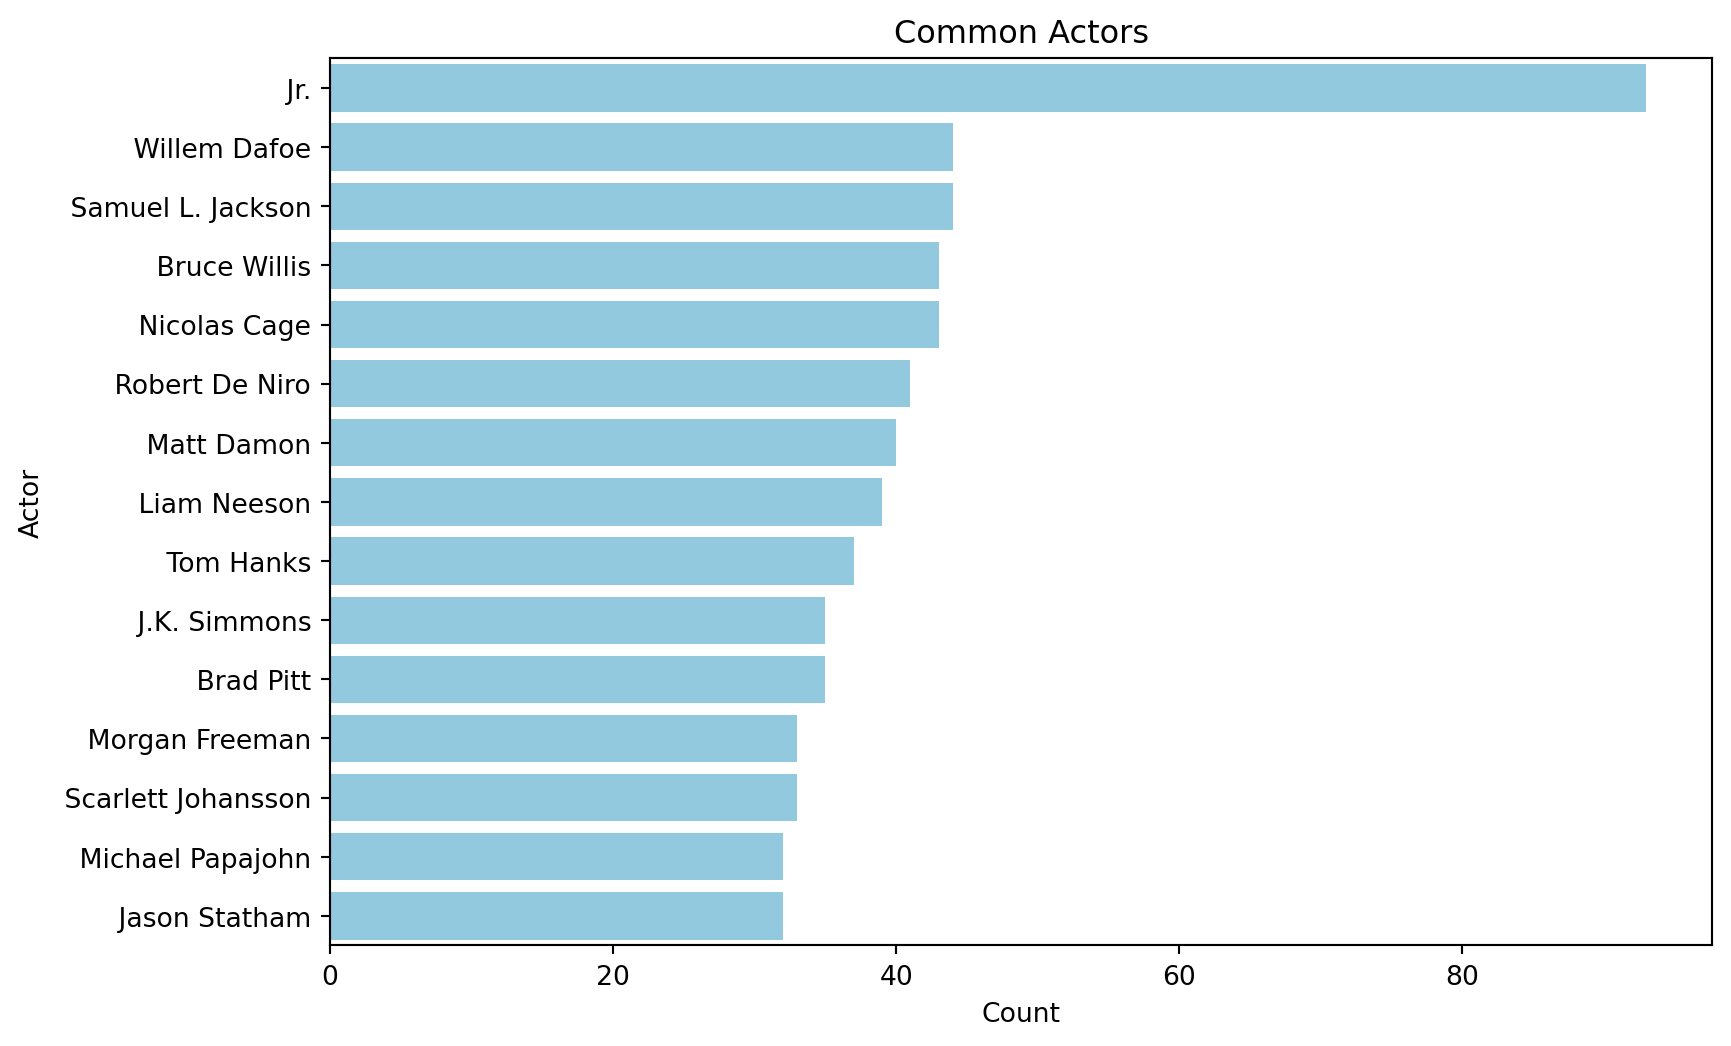

In [15]:
#separating actors and exploding
movie_content_df['actors_list'] = movie_content_df['cast_names'].str.split(',')
movies_exploded = movie_content_df.explode('actors_list')

#bar chart for actor counts
actors_count = movies_exploded['actors_list'].value_counts().sort_values(ascending = False)
plt.figure(figsize = (12, 6))
sns.barplot(x = actors_count.values[:15], y = actors_count.index[:15], orient = 'h', color = "skyblue")
plt.xlabel('Count')
plt.ylabel('Actor')
plt.title('Common Actors')
plt.yticks(rotation = 0)
plt.subplots_adjust(left = .3)
plt.show()

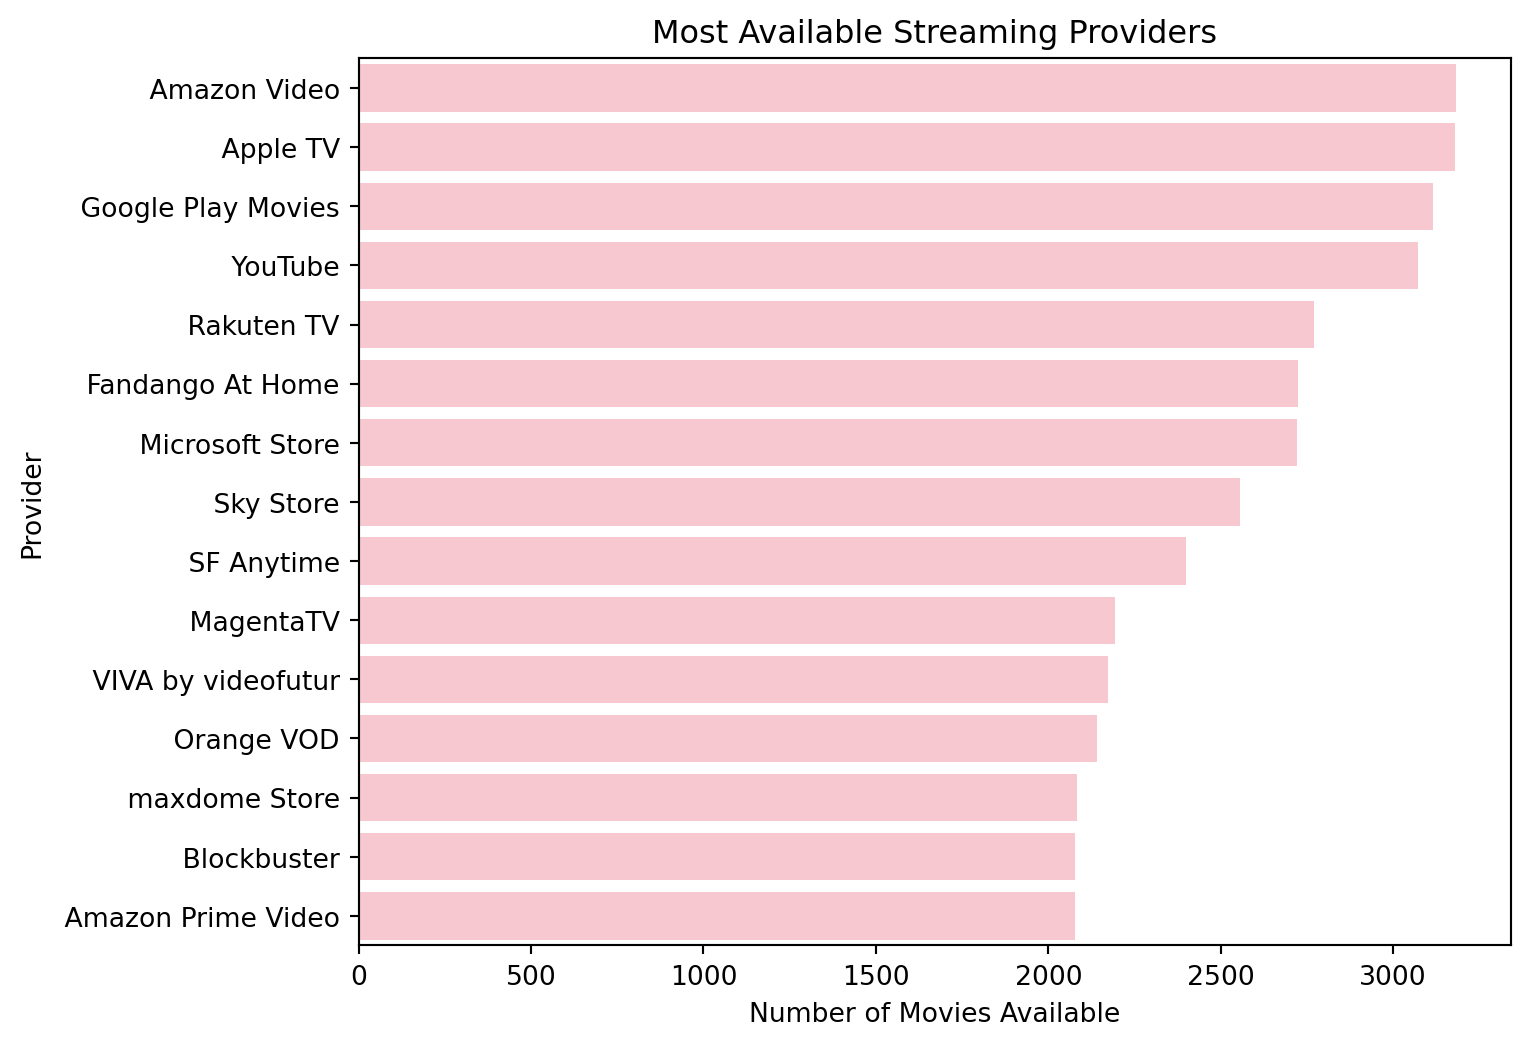

In [16]:
movie_content_df['providers_list'] = movie_content_df['watch_providers'].str.split(',')
movies_exploded = movie_content_df.explode('providers_list')

# Count the occurrences of each provider
provider_counts = movies_exploded['providers_list'].value_counts()

# Bar chart for the top providers
plt.figure(figsize=(12,6))
sns.barplot(x=provider_counts.values[:15], y=provider_counts.index[:15], color="pink")
plt.xlabel('Number of Movies Available')
plt.ylabel('Provider')
plt.title('Most Available Streaming Providers')
plt.subplots_adjust(left=0.4)
plt.show()

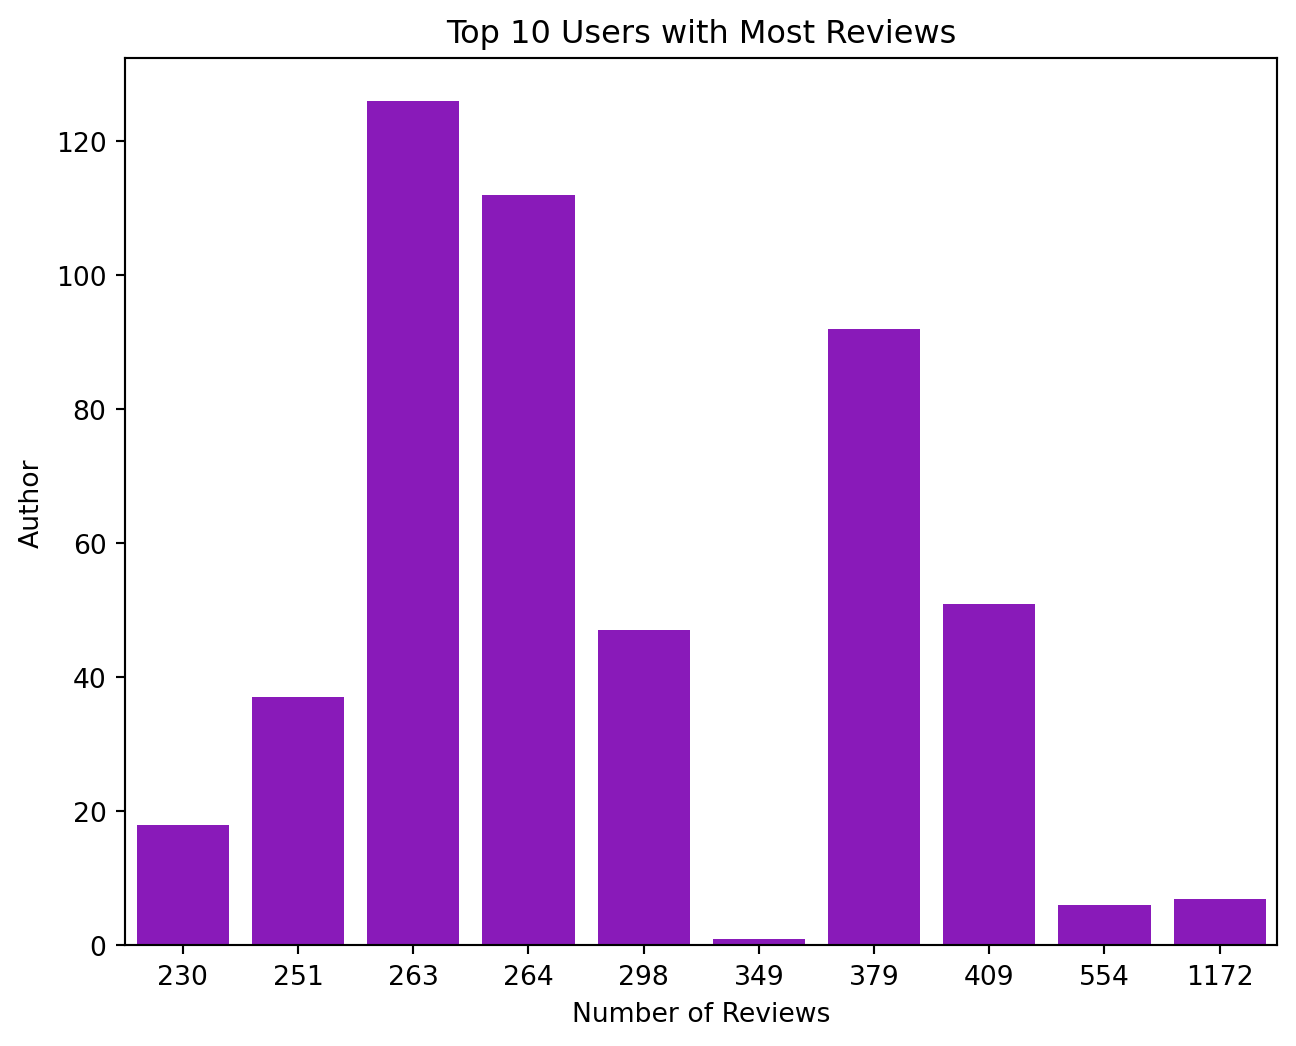

In [17]:
#counting how many times an author reviewed movies
user_review_counts = movie_reviews_df['user_id'].value_counts()

# Bar chart for top reviewers
plt.figure(figsize=(12,6))
sns.barplot(x=user_review_counts.values[:10], y=user_review_counts.index[:10], color="darkviolet")
plt.xlabel('Number of Reviews')
plt.ylabel('Author')
plt.title('Top 10 Users with Most Reviews')
plt.subplots_adjust(left=0.4)
plt.show()

In [18]:
# Combine relevent features
movie_content_df["combined_features"] = (
    movie_content_df["genre_ids"].fillna("").str.replace(",", " ") + " | " +  
    movie_content_df["cast_names"].fillna("").str.replace(",", " ") + " | " +  
    movie_content_df["watch_providers"].fillna("").str.replace(",", " ")
)

# TF-IDF Vectorization
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_content_df["combined_features"])
print("TF-IDF Matrix Shape:", tfidf_matrix.shape)

# Compute Cosine Similarity
from sklearn.metrics.pairwise import cosine_similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
print("Cosine Similarity Matrix Shape:", cosine_sim.shape)
print("Sample Cosine Similarity Scores:\n", cosine_sim[:5, :5])

TF-IDF Matrix Shape: (4000, 25462)


Cosine Similarity Matrix Shape: (4000, 4000)
Sample Cosine Similarity Scores:
 [[1.         0.02490704 0.01305899 0.01180896 0.00451682]
 [0.02490704 1.         0.01944315 0.0434806  0.00603281]
 [0.01305899 0.01944315 1.         0.02217178 0.        ]
 [0.01180896 0.0434806  0.02217178 1.         0.01443588]
 [0.00451682 0.00603281 0.         0.01443588 1.        ]]


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# TF-IDF
movie_content_df["combined_features"] = (
    movie_content_df["genre_ids"].fillna("").str.replace(",", " ") + " | " +
    movie_content_df["cast_names"].fillna("").str.replace(",", " ") + " | " +
    movie_content_df["watch_providers"].fillna("").str.replace(",", " ")
)

tfidf_vectorizer = TfidfVectorizer(stop_words="english", min_df=2)
tfidf_matrix = tfidf_vectorizer.fit_transform(movie_content_df["combined_features"])

# add numeric features(need standardization)
scaler = MinMaxScaler()
numeric_features = movie_content_df[["rating_average", "vote_count"]].fillna(0)
numeric_matrix = scaler.fit_transform(numeric_features)

# integrate TFIDF and numeric features
final_matrix = np.hstack((tfidf_matrix.toarray(), numeric_matrix))

# Linear Kernel similarity
from sklearn.metrics.pairwise import linear_kernel
linear_sim = linear_kernel(final_matrix, final_matrix)

print("Linear Kernel Similarity Matrix Shape:", linear_sim.shape)
print("Sample Linear Kernel Similarity Scores:\n", linear_sim[:5, :5])

Linear Kernel Similarity Matrix Shape: (4000, 4000)
Sample Linear Kernel Similarity Scores:
 [[1.64266135 0.50556474 0.49307841 0.65182006 0.48452237]
 [0.50556474 1.36016254 0.37944795 0.52348334 0.36603418]
 [0.49307841 0.37944795 1.36000014 0.50217186 0.36000004]
 [0.65182006 0.52348334 0.50217186 1.64000005 0.4944359 ]
 [0.48452237 0.36603418 0.36000004 0.4944359  1.36000001]]


In [20]:
from difflib import get_close_matches

def content_based_movie_recs_print(movie_title, movie_content_df, cosine_sim, top_n=11):
    # prepprocess input: remove space and lowercase
    clean_title = movie_title.strip().lower()

    # preprocess movie title
    movie_content_df["clean_title"] = movie_content_df["title"].str.strip().str.lower()

    # find the most similar movie
    possible_matches = get_close_matches(clean_title, movie_content_df["clean_title"], n=1, cutoff=0.7)

    
    if possible_matches:
        clean_title = possible_matches[0]

    
    movie_idx = movie_content_df[movie_content_df["clean_title"] == clean_title].index

    if movie_idx.empty:
        return f"Movie '{movie_title.strip()}' not found. Please check the title."


    movie_idx = movie_idx[0]

   
    similarity_scores = list(enumerate(cosine_sim[movie_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

   
    top_movies = similarity_scores[1:top_n+1]

    
    recommendations = movie_content_df.iloc[[i[0] for i in top_movies]][["title", "genre_ids", "rating_average"]]

    print(f"\n🎬 Using matched movie: {movie_content_df.iloc[movie_idx]['title']}")
    print(f"\n📌 Top 10 movies similar to '{movie_title.strip()}':")
    for i, row in enumerate(recommendations.itertuples(), start=1):
        print(f"{i}. {row.title} (Genre: {row.genre_ids}, Rating: {row.rating_average})")

    return recommendations

In [21]:
recommendations1 = content_based_movie_recs_print("The Gorgee", movie_content_df, cosine_sim)
recommendations2 = content_based_movie_recs_print("Paprika", movie_content_df, cosine_sim)


🎬 Using matched movie: The Gorge

📌 Top 10 movies similar to 'The Gorgee':
1. Alien (Genre: Horror, Science Fiction, Rating: 8)
2. The New Mutants (Genre: Science Fiction, Horror, Action, Rating: 6)
3. More (Genre: Animation, Science Fiction, Rating: 8)
4. Sherlock Holmes (Genre: Action, Adventure, Crime, Mystery, Rating: 7)
5. The Double (Genre: Thriller, Drama, Rating: 7)
6. Split (Genre: Horror, Thriller, Rating: 7)
7. The Huntsman: Winter's War (Genre: Action, Adventure, Drama, Rating: 6)
8. Lifted (Genre: Family, Animation, Science Fiction, Comedy, Rating: 8)
9. A Monster Calls (Genre: Fantasy, Adventure, Family, Rating: 7)
10. Red Lights (Genre: Thriller, Rating: 6)

🎬 Using matched movie: Paprika

📌 Top 10 movies similar to 'Paprika':
1. Vampire Hunter D: Bloodlust (Genre: Animation, Fantasy, Horror, Action, Adventure, Science Fiction, Rating: 8)
2. Evangelion: 3.0+1.0 Thrice Upon a Time (Genre: Animation, Action, Science Fiction, Drama, Rating: 8)
3. Evangelion: 3.0 You Can (N

In [22]:
from difflib import get_close_matches

def content_based_movie_recs_linear(movie_title, movie_content_df, linear_sim, top_n=10):
    # prepprocess input: remove space and lowercase
    clean_title = movie_title.strip().lower()

    # preprocess movie title
    movie_content_df["clean_title"] = movie_content_df["title"].str.strip().str.lower()

    # find the most similar movie
    possible_matches = get_close_matches(clean_title, movie_content_df["clean_title"], n=1, cutoff=0.7)


    if possible_matches:
        clean_title = possible_matches[0]
    else:
        return f"Movie '{movie_title.strip()}' not found. Please check the title."


    movie_idx = movie_content_df[movie_content_df["clean_title"] == clean_title].index
    if movie_idx.empty:
        return f"Movie '{movie_title.strip()}' not found. Please check the title."

    movie_idx = movie_idx[0]


    similarity_scores = list(enumerate(linear_sim[movie_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    # Top 10
    top_movies = similarity_scores[1:top_n+1]

  
    recommendations = movie_content_df.iloc[[i[0] for i in top_movies]][["title", "genre_ids", "rating_average"]]

    print(f"\n🎬 Using matched movie: {movie_content_df.iloc[movie_idx]['title']}")
    print(f"\n📌 Top 10 movies similar to '{movie_title.strip()}':")
    for i, row in enumerate(recommendations.itertuples(), start=1):
        print(f"{i}. {row.title} (Genre: {row.genre_ids}, Rating: {row.rating_average})")

    return recommendations

In [23]:
recommended_movies_linear1 = content_based_movie_recs_linear("The Gorgee", movie_content_df, linear_sim)
recommended_movies_linear2 = content_based_movie_recs_linear("paprika", movie_content_df, linear_sim)


🎬 Using matched movie: The Gorge

📌 Top 10 movies similar to 'The Gorgee':
1. The Consequences of "The Premiere of "The Making of "The Lumberjack's Daughter""" (Genre: Comedy, Crime, Rating: 10)
2. The Shawshank Redemption (Genre: Drama, Crime, Rating: 9)
3. The Home (Genre: Horror, Thriller, Rating: 10)
4. Lilim (Genre: Horror, Thriller, Drama, Rating: 10)
5. The Dark Knight (Genre: Drama, Action, Crime, Thriller, Rating: 9)
6. Queen Mom (Genre: Drama, Comedy, Rating: 10)
7. What's Next? (Genre: War, Documentary, Drama, Rating: 10)
8. Balada Para Un Loco (Genre: Music, Comedy, Rating: 10)
9. Pludselig Stod Verden Stille (Genre: Documentary, Rating: 10)
10. The Green Mile (Genre: Fantasy, Drama, Crime, Rating: 9)

🎬 Using matched movie: Paprika

📌 Top 10 movies similar to 'paprika':
1. Tokyo Godfathers (Genre: Animation, Drama, Comedy, Rating: 8)
2. Vampire Hunter D: Bloodlust (Genre: Animation, Fantasy, Horror, Action, Adventure, Science Fiction, Rating: 8)
3. Spirited Away (Genre: A

In [24]:
#| echo: false
movie_reviews_df = pd.read_csv('../data/movie_reviews_data.csv')
movie_content_df = pd.read_csv('../data/movie_content_processed.csv')
movies_df = pd.read_csv('../data/movies_data.csv')
pd.options.mode.chained_assignment = None

In [25]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import ast

# Join the movies and reviews dataframes
movies_merged = pd.merge(movies_df, movie_reviews_df, left_on='id', right_on='movie_id')

# Pivot so that rows are movies, columns are a user, and values are ratings
movies_pivot = movies_merged.pivot_table(index="title",columns="id",values="user_rating").fillna(0)

# Create Compressed Sparse Row (CSR) matrix
movies_matrix = csr_matrix(movies_pivot.values)

# Fit KNN model with cosine similarity as distance metric
knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
knn.fit(movies_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [26]:
def collaborative_based_movie_recs(title, movies_pivot, movies_merged, knn, num_recs=10):
    # Check if movie is within dataset
    if title not in movies_pivot.index:
        return f"Movie '{title}' not found in the dataset."
      
    # List only popular streaming services to include
    popular_streaming_services = [
    'Netflix', 'Amazon Prime Video', 'Hulu', 'Disney+', 'Apple TV', 'HBO Max', 
    'YouTube', 'Google Play Movies', 'Peacock', 'Paramount+',
    'Max', 'Mubi', 'Amazon Video', 'Netflix basic with Ads', 'Hoopla', 'Vudu']
    
    # Get index of movie to get recommendations for
    query_idx = movies_pivot.index.get_loc(title)
    
    # Given KNN model, find top 10 most similar movies based on user ratings
    distances, indices = knn.kneighbors(movies_pivot.iloc[query_idx, :].values.reshape(1, -1), n_neighbors=min(num_recs + 1, len(movies_pivot)))

    
    recommendations = []
    for i in range(1, len(indices.flatten())):  # Skip the first movie (it's itself)
        # Extract movie name and information
        movie_name = movies_pivot.index[indices.flatten()[i]]
        movie_info = movie_content_df[movie_content_df['movie_id'] == movies_merged[movies_merged['title'] == movie_name]['movie_id'].iloc[0]]
        
        # Check that the movie exists in content DataFrame
        if not movie_info.empty:
            # Extract movie rating and genres
            avg_rating = movie_info['rating_average'].iloc[0]
            genre_ids = movie_info['genre_ids'].iloc[0]
            # Convert genre ids to lists and join to make a string
            if isinstance(genre_ids, str):
                genre_ids = eval(genre_ids)
            genre_str = ", ".join(map(str, genre_ids))
            
            # Collect watch provider information for each movie
            watch_providers = movie_info['watch_providers'].iloc[0]
            # Format info so it only contains the popular streaming services
            if isinstance(watch_providers, float):
              watch_providers = ""
            filtered_watch_providers = [provider.strip() for provider in watch_providers.split(',') 
                            if any(popular.lower() in provider.lower() for popular in popular_streaming_services)]
            formatted_watch_providers = ", ".join(filtered_watch_providers)
            # Add all information to list of recommendations
            recommendations.append((movie_name, genre_str, avg_rating, formatted_watch_providers))
    
    print(f"🎬 Using matched movie: {title}\n")
    print(f"📌 Top {num_recs} movies similar to '{title}':")
    
    # Print out movie information for each recommendation in formatted way
    for i, (movie_name, genre, rating, watch_providers) in enumerate(recommendations, start=1):
        print(f"{i}. {movie_name} (Genre: {genre}, Rating: {rating})")
        print(f"   📺 Where to stream: {watch_providers}")
        print()

In [27]:
collaborative_based_movie_recs('Anora', movies_pivot, movies_merged, knn, num_recs=10)

🎬 Using matched movie: Anora

📌 Top 10 movies similar to 'Anora':
1. Zoolander (Genre: Comedy, Rating: 6.2)
   📺 Where to stream: Hoopla, Paramount+ Roku Premium Channel, Paramount Plus Apple TV Channel, Amazon Video, maxdome Store, Premiere Max, Paramount+ Amazon Channel, Google Play Movies, Netflix, YouTube, Apple TV

2. Zombieland: Double Tap (Genre: Comedy, Horror, Action, Rating: 6.921)
   📺 Where to stream: Amazon Prime Video with Ads, Amazon Video, maxdome Store, Premiere Max, Netflix basic with Ads, Max, Google Play Movies, Netflix, Amazon Prime Video, YouTube, Apple TV

3. Zombieland (Genre: Comedy, Horror, Rating: 7.259)
   📺 Where to stream: Max Amazon Channel, ShowMax, Amazon Video, maxdome Store, Premiere Max, Netflix basic with Ads, Max, Google Play Movies, Netflix, Amazon Prime Video, YouTube, Apple TV

4. Zodiac (Genre: Crime, Drama, Mystery, Thriller, Rating: 7.525)
   📺 Where to stream: Max Amazon Channel, Paramount Plus Apple TV Channel, Amazon Video, maxdome Store, 

In [28]:
#| echo: false
def content_based_movie_recs(movie_title, movie_content_df, cosine_sim, top_n=11):
    # prepprocess input: remove space and lowercase
    clean_title = movie_title.strip().lower()

    # preprocess movie title
    movie_content_df["clean_title"] = movie_content_df["title"].str.strip().str.lower()

    # find the most similar movie
    possible_matches = get_close_matches(clean_title, movie_content_df["clean_title"], n=1, cutoff=0.7)

    
    if possible_matches:
        clean_title = possible_matches[0]

    
    movie_idx = movie_content_df[movie_content_df["clean_title"] == clean_title].index

    if movie_idx.empty:
        return f"Movie '{movie_title.strip()}' not found. Please check the title."


    movie_idx = movie_idx[0]

   
    similarity_scores = list(enumerate(cosine_sim[movie_idx]))
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)[1:top_n+1]

   
    top_movies = similarity_scores[1:top_n+1]

    
    recommendations = movie_content_df.iloc[[i[0] for i in top_movies]][["title", "genre_ids", "rating_average"]]

    return recommendations

In [29]:
def final_movie_recs(title):
  # Retrieve top 100 content based recommendations
  top_100_movies = content_based_movie_recs(title, movie_content_df, cosine_sim, top_n=101)
  
  # List only popular streaming services to include
  popular_streaming_services = [
    'Netflix', 'Amazon Prime Video', 'Hulu', 'Disney+', 'Apple TV', 'HBO Max', 
    'YouTube', 'Google Play Movies', 'Peacock', 'Paramount+',
    'Max', 'Mubi', 'Amazon Video', 'Netflix basic with Ads', 'Hoopla', 'Vudu']
      
  # Extract row with movie content for given movie
  movie_row = movie_content_df[movie_content_df["title"] == title]
  
  # Check if movie exists in content DataFrame
  if not movie_row.empty:
    # Add movie to top 100 DataFrame so that this can be fed into other recommender
    top_100_movies = pd.concat([top_100_movies, movie_row], ignore_index=True)
  # If movie does not exist in contet DataFrame, let user know
  elif movie_row.empty:
    return f"Movie '{title}' not found in the dataset."
  
  # Extract specific movie id
  movie_id = movie_row["movie_id"].values[0] if not movie_row.empty else None
  
  # Check if movie does not have reviews in the reviews DataFrame
  if movie_id not in movie_reviews_df["movie_id"].values:
      # Extract movie id and title of given movie
      input_movie_id = movie_row["movie_id"].values[0]
      input_movie_title = movie_row["title"].values[0]
      
      # Remove the given movie from top 100 movies DataFrame
      top_100_movies = top_100_movies[
            (top_100_movies["movie_id"] != input_movie_id) & 
            (top_100_movies["title"] != input_movie_title)]
      
      print(f"🎬 Using matched movie: {input_movie_title}\n")
      print(f"📌 Top 10 movies similar to '{input_movie_title}':")
      
      # Format and print top 10 rows of the top 100 DataFrame
      for counter, (i, row) in enumerate(top_100_movies.head(10).iterrows(), 1):
        # Extract genre id for each movie
        genres = row['genre_ids']
        # If genre is a string, convert to list and format to joined string for printing
        if isinstance(genres, str):
            genres = eval(genres)
        genres = ', '.join(genres)
        print(f"{counter}. {row['title']} (Genre: {genres}, Rating: {row['rating_average']:.2f})")
        
        # Select and format only the popular watch providers
        available_providers = [provider for provider in row['watch_providers'].split(', ') if provider in popular_streaming_services]
        
        # Print out all available streaming services
        if available_providers:
            print(f"   📺 Where to stream: {', '.join(available_providers)}")
        print()
  
  # If movie does have reviews in the reviews DataFrame
  else:
    # Select all unique movies in the top 100 content based recommendations
    movie_ids_set = set(top_100_movies["movie_id"])
    # Subset movies_df to include only the top 100 movies 
    movies_subset = movies_df[movies_df["id"].isin(movie_ids_set)]
    # Subset movie_reviews_df to incude only the top 100 movies
    reviews_subset = movie_reviews_df[movie_reviews_df["movie_id"].isin(movie_ids_set)]
    # Merge both subsetted DataFrames: movies and their reviews
    movies_merged = movies_subset.merge(reviews_subset, left_on="id", right_on="movie_id")
    
    # Pivot the merged table so that rows are movies, columns are users, values are those users ratings
    movies_pivot = movies_merged.pivot_table(index="title",columns="id",values="user_rating").fillna(0)
    
    # Create Compressed Sparse Row (CSR) matrix of pivoted table
    movies_matrix = csr_matrix(movies_pivot.values)
    
    # Fit KNN model with cosine similarity as distance metric
    knn = NearestNeighbors(metric = "cosine", algorithm = "brute")
    knn.fit(movies_matrix)
    
    # Run top 100 recs through collaborative recommender to get top 10 recommendations
    final_recommendations = collaborative_based_movie_recs(title, movies_pivot, movies_merged, knn, num_recs=10)
    
    return final_recommendations

In [30]:
final_movie_recs("Anora")

🎬 Using matched movie: Anora

📌 Top 10 movies similar to 'Anora':
